Preliminary CNN playground

In [ ]:
# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
     break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
  print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# define model
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X, y, epochs=1000, verbose=0)

In [ ]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.68726]]


# Data import

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/dbonacorsi/AML_Adv_AA1920/master/datasets/monthly-car-sales.csv'

names = ['Month', 'Sales']
series = pd.read_csv(url, names=names, header=0, index_col=0)
data = series.values

series

,Sales
Month,
1960-01,6550
1960-02,8728
1960-03,12026
1960-04,14395
1960-05,14587
...,...
1968-08,16722
1968-09,14385
1968-10,21342


In [ ]:
print(series.shape)

(108, 1)


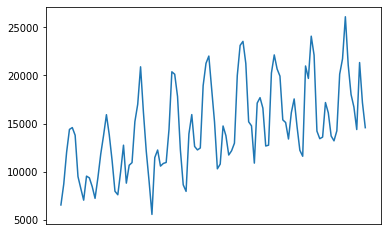

In [ ]:
from matplotlib import pyplot

pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

# CNN

In [ ]:
# evaluate cnn for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

In [ ]:
# transform list into supervised learning format    #<---- (same as seen for MLP)
def series_to_supervised(data, n_in, n_out=1):
  df = DataFrame(data)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # put it all together
  agg = concat(cols, axis=1)
  # drop rows with NaN values
  agg.dropna(inplace=True)
  return agg.values

In [ ]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

In [ ]:
# fit a model
def model_fit(train, config):
  # unpack config
  n_input, n_filters, n_kernel, n_epochs, n_batch = config                      #<---- CNN
  # prepare data
  data = series_to_supervised(train, n_input)
  train_x, train_y = data[:, :-1], data[:, -1]
  train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))            #<---- CNN
  # define model
  model = Sequential()                                                          #<---- CNN
  model.add(Conv1D(n_filters, n_kernel, activation='relu',
                   input_shape=(n_input, 1)))
  model.add(Conv1D(n_filters, n_kernel, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config):
  # unpack config
  n_input, _, _, _, _ = config                                                  #<---- CNN
  # prepare data
  x_input = array(history[-n_input:]).reshape((1, n_input, 1))                  #<---- CNN
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  print(' > %.3f' % error)
  return error

In [ ]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
  # fit and evaluate the model n times
  scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
  return scores

In [ ]:
# summarize model performance
def summarize_scores(name, scores):
  # print a summary
  scores_m, score_std = mean(scores), std(scores)
  print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) # box and whisker plot
  pyplot.boxplot(scores)
  pyplot.show()

 > 1710.923
 > 1438.504
 > 1580.071
 > 1540.382
 > 1539.658
 > 1550.365
 > 1486.841
 > 1548.738
 > 1543.109
 > 1504.044
 > 1483.333
 > 1493.979
 > 1475.771
 > 1542.153
 > 1424.229
 > 1569.372
 > 1571.160
 > 1601.493
 > 1488.766
 > 1659.756
 > 1553.310
 > 1542.186
 > 1493.676
 > 1505.841
 > 1422.640
 > 1618.587
 > 1642.337
 > 1512.016
 > 1476.829
 > 1573.962
CNN: 1536.468 RMSE (+/- 65.916)


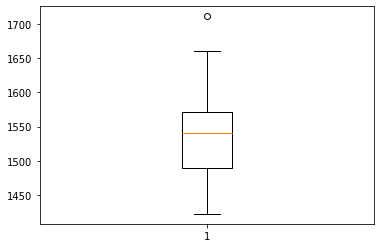

In [ ]:
# data split
n_test = 12
# define config
config = [36, 256, 3, 100, 100]                 #<---- CNN
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('CNN', scores)